In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
26,757 cases (7 day average) as of Mon 23 Aug, -62.3 since Sun 22 Aug
790 hospitalised (7 day average) as of Wed 25 Aug, +0.0 since Wed 25 Aug
89 died (7 day average) as of Mon 23 Aug, +6.3 since Sun 22 Aug


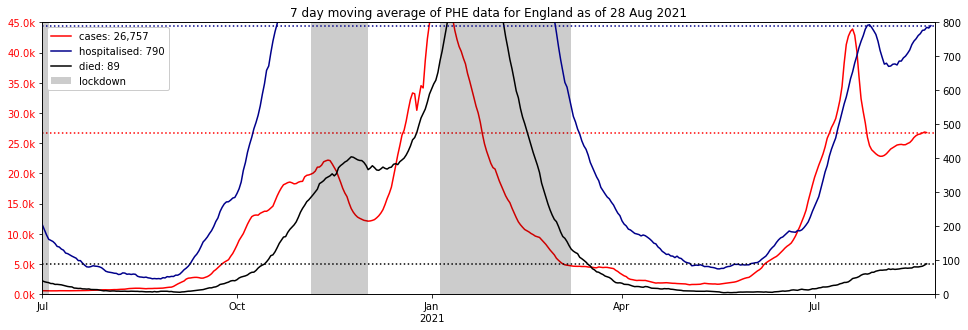

In [3]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=45_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=800)

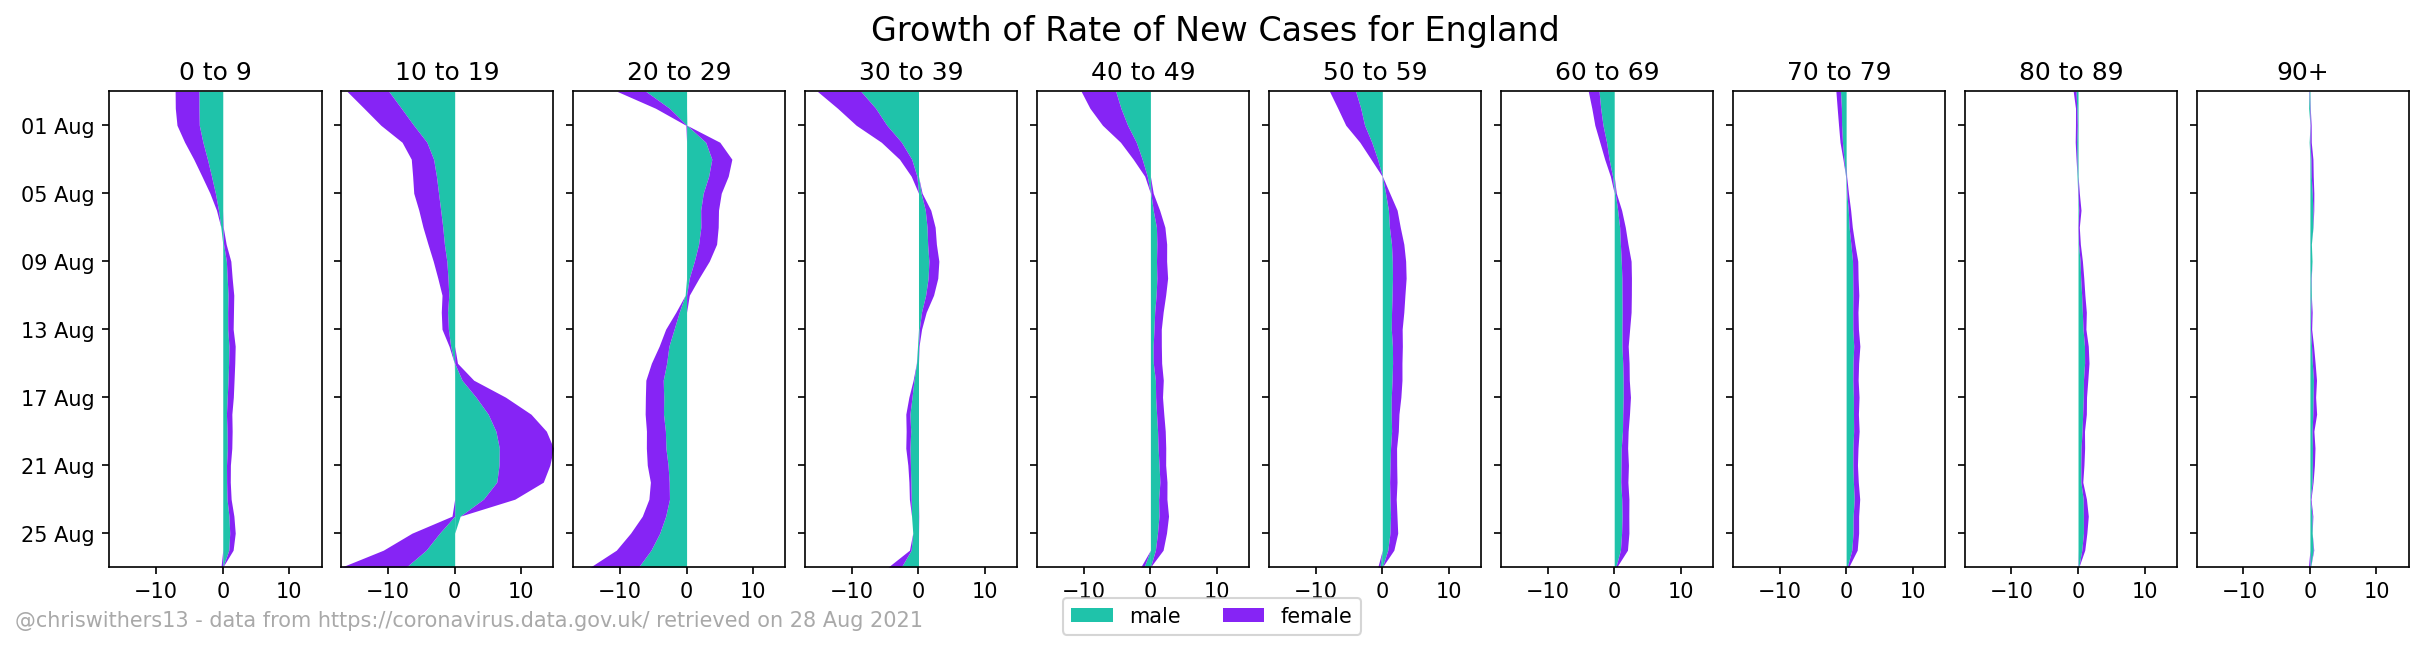

In [4]:
demographic_stream_plot('Growth of Rate of New Cases', order=2, figsize=(16, 4))

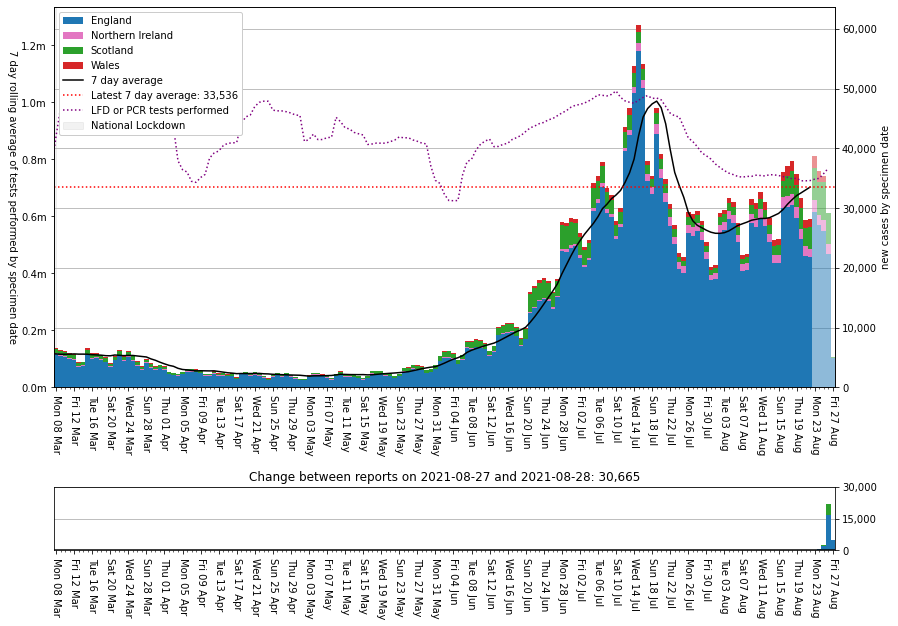

In [5]:
plot_areas(for_date, 'cases_nations', date_format='%a %d %b')

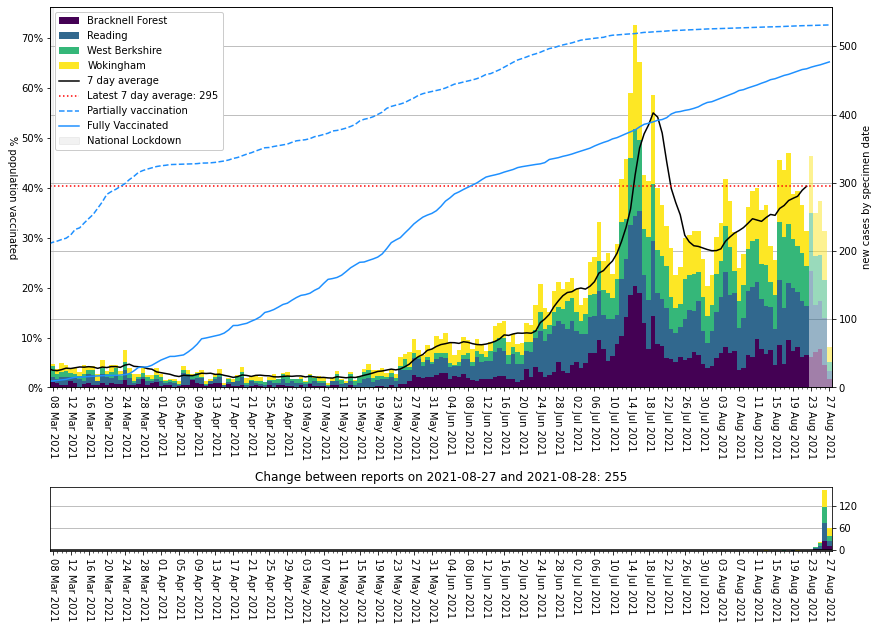

In [6]:
plot_areas(for_date, areas=my_areas, lines=population_vaccinated)

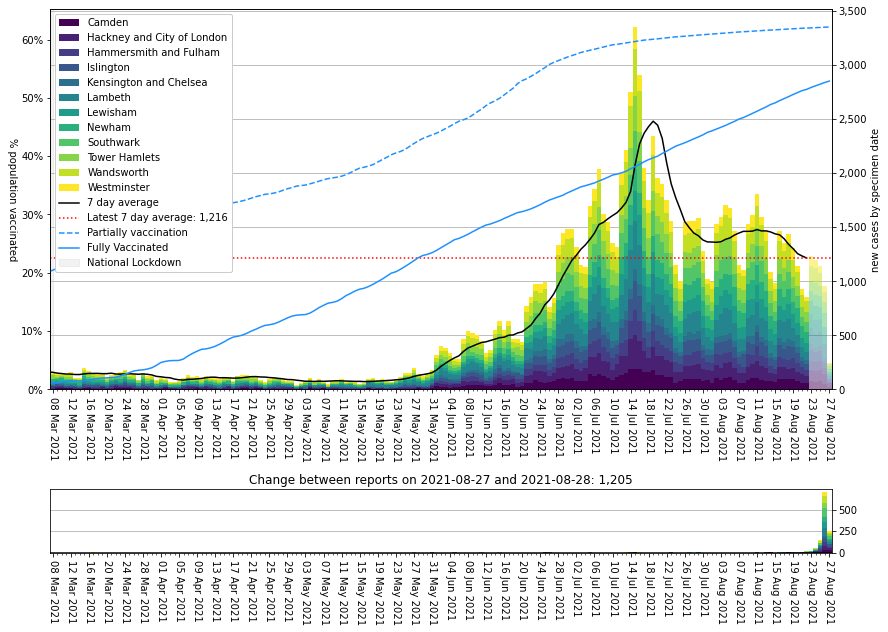

In [7]:
plot_areas(for_date, areas=london_areas, lines=population_vaccinated)

In [8]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [9]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000045,East Dunbartonshire,935.198822,1016.0,2021-08-27
S12000050,North Lanarkshire,930.368808,3176.0,2021-08-27
S12000039,West Dunbartonshire,918.700101,817.0,2021-08-27
N09000006,Fermanagh and Omagh,892.697428,1048.0,2021-08-27
N09000005,Derry City and Strabane,818.989450,1239.0,2021-08-27
S12000018,Inverclyde,789.203085,614.0,2021-08-27
S12000038,Renfrewshire,772.752652,1384.0,2021-08-27
S12000029,South Lanarkshire,763.111097,2446.0,2021-08-27
S12000011,East Renfrewshire,748.455982,715.0,2021-08-27


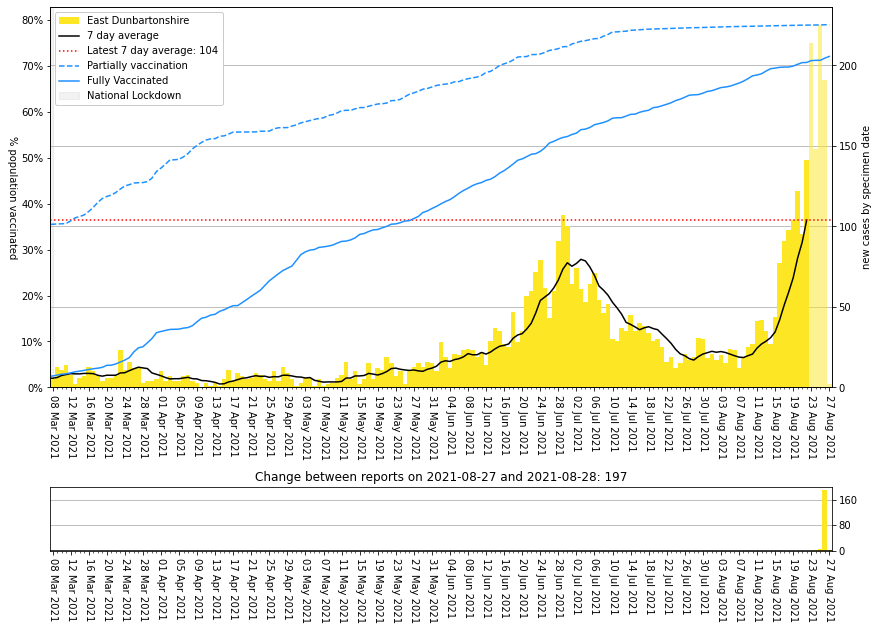

In [10]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=population_vaccinated)

In [11]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000049,Glasgow City,683.124842,4325.0,2021-08-27
S12000050,North Lanarkshire,930.368808,3176.0,2021-08-27
E08000025,Birmingham,253.280739,2892.0,2021-08-27
S12000036,City of Edinburgh,544.072543,2856.0,2021-08-27
E06000052,Cornwall and Isles of Scilly,497.200080,2843.0,2021-08-27
S12000029,South Lanarkshire,763.111097,2446.0,2021-08-27
E08000035,Leeds,285.448074,2264.0,2021-08-27
N09000003,Belfast,503.577437,1730.0,2021-08-27
E06000023,"Bristol, City of",368.598355,1708.0,2021-08-27


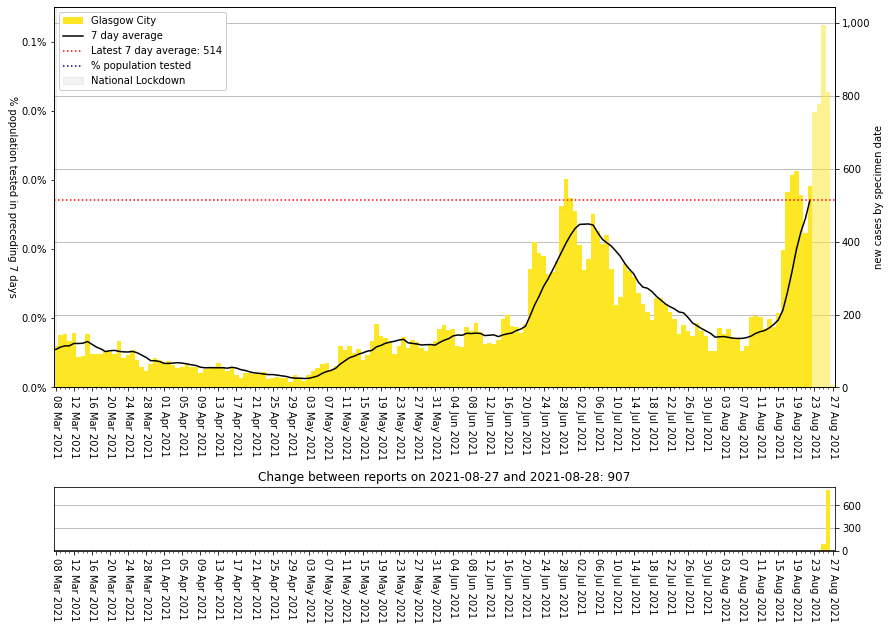

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

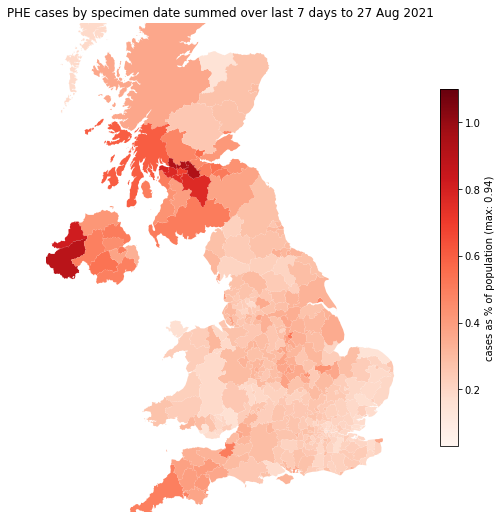

Loading BokehJS ...

In [13]:
summed_maps(for_date, vmax=1.1)

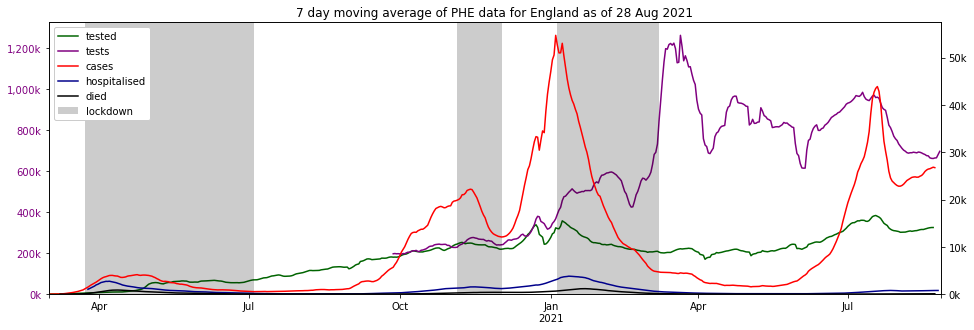

In [14]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

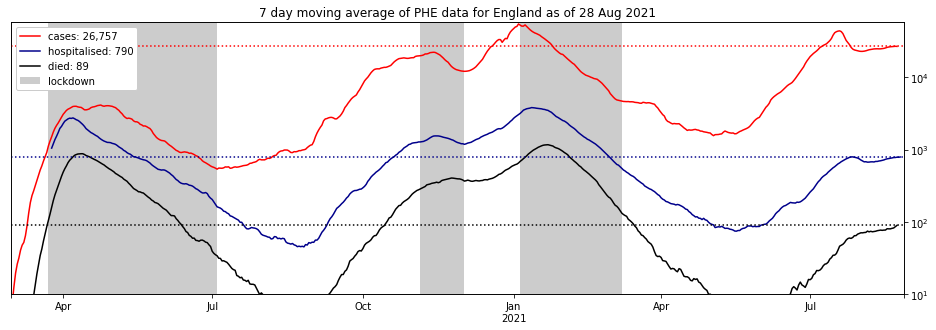

In [15]:
plot_summary(earliest_date='2020-02-29', show_latest='lines', log=True,
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

In [16]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,27 Aug 21,"+35,534,625","+40,230,336","+35,534,625","+115,249","+38,392","+115,249"
Northern Ireland,27 Aug 21,"+1,157,174","+1,281,246","+1,157,174","+1,616","+2,153","+1,616"
Scotland,27 Aug 21,"+3,640,865","+4,098,078","+3,640,865","+11,383","+2,615","+11,383"
Wales,27 Aug 21,"+2,174,937","+2,349,268","+2,174,937",+0,+0,+0


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,35534625.0,40230336.0,4695711.0,56286961,63.131184,8.342449,28.526367
1,Northern Ireland,N92000002,1157174.0,1281246.0,124072.0,1893667,61.107576,6.551944,32.340480
2,Scotland,S92000003,3640865.0,4098078.0,457213.0,5463300,66.642231,8.368806,24.988963
3,Wales,W92000004,2174937.0,2349268.0,174331.0,3152879,68.982571,5.529264,25.488165


'partial: 47,958,928 (71.8%), full: 42,507,601'

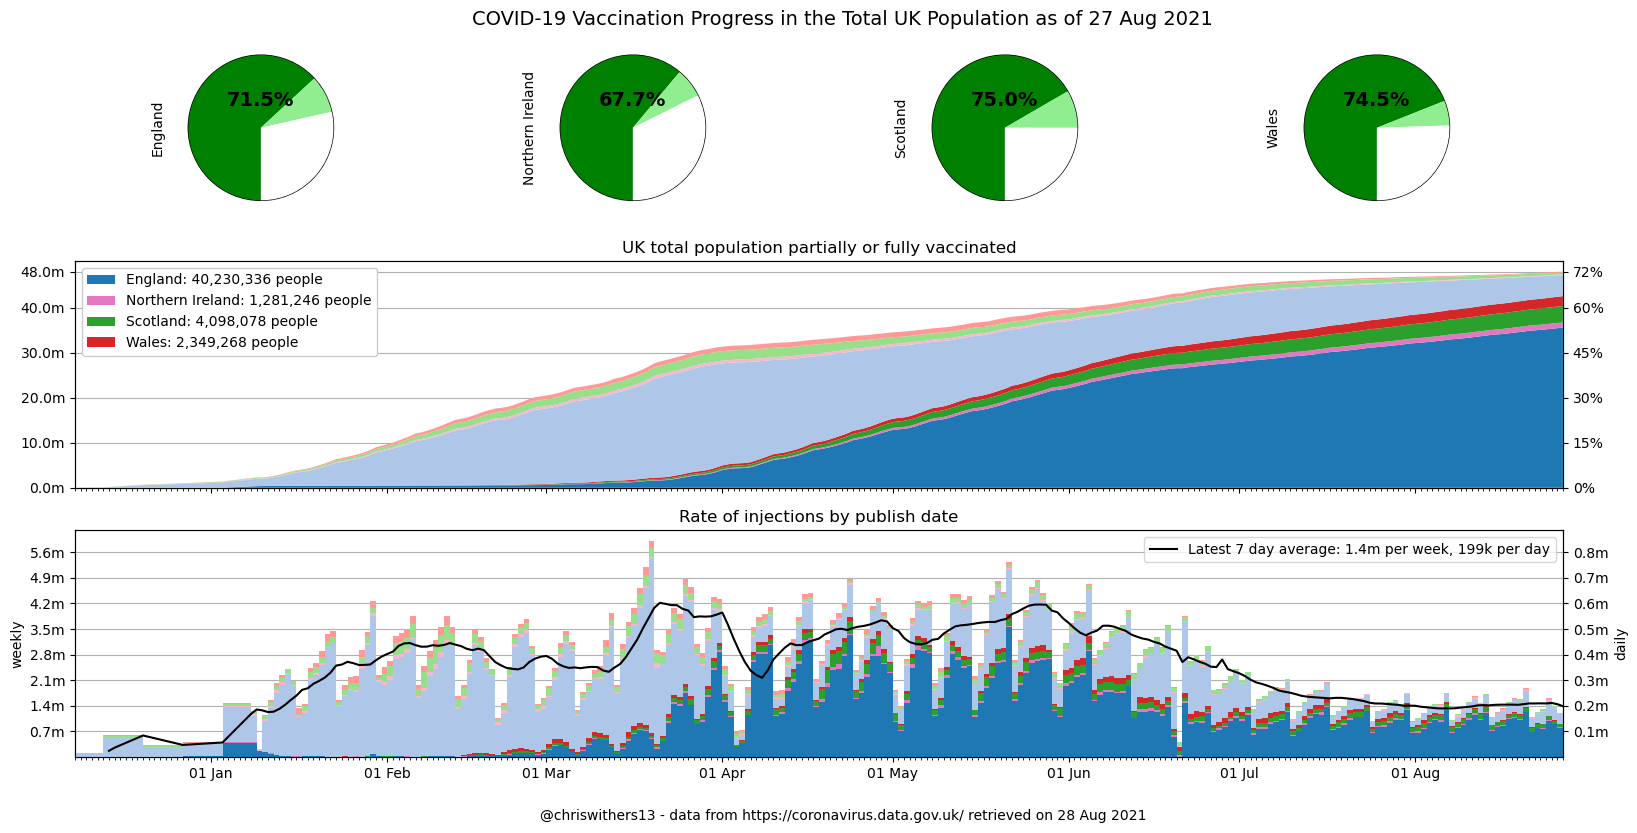

In [17]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")